In [353]:
import pandas as pd
import numpy as np
import yfinance as yf
import sqlalchemy as sqla

In [354]:
db_path = 'sqlite:///backtesting.sqlite'
engine = sqla.create_engine(db_path)
%load_ext sql
%sql $db_path

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


# 1. Getting stock histories

## Option 1: *via Yfinance (if no history has been persisted into SQLite)*

### Extracting and loading data

In [462]:
# fetching the list of symbols
symbols = pd.read_csv('biotech.csv').squeeze().tolist()
formatted_symbols = ' '.join(symbols)

In [463]:
# fetching histories for each symbol through yfinance API
raw_historic_data = yf.download(
    tickers=formatted_symbols,
    period='3y',
    interval='1d',
    group_by='ticker'
)

[*********************100%***********************]  33 of 33 completed


In [635]:
all_true_or_not = raw_historic_data.notnull().all(axis=0).groupby(level=0).all()
all_false_symbols = all_true_or_not[all_true_or_not == False]
all_true_symbols = all_true_or_not[all_true_or_not == True]
historic_data = raw_historic_data.drop(labels=all_false_symbols.index, axis=1, level=0)

In [636]:
symbols = np.unique([symbol for symbol, _ in historic_data.columns])

In [638]:
symbols

array(['ANIP', 'ARVN', 'ARWR', 'AXSM', 'BMRN', 'BPMC', 'CRSP', 'DNLI',
       'EXAS', 'EXEL', 'FATE', 'GILD', 'HALO', 'KRYS', 'MYGN', 'NBIX',
       'NTLA', 'NVAX', 'PRTA', 'RGNX', 'SRRA', 'TVTX', 'TWST', 'VIVO',
       'XNCR'], dtype='<U4')

## Persisting to SQLite database

In [639]:
tables = %sql SELECT name FROM sqlite_master WHERE type='table'
tables = tables.DataFrame().squeeze()

 * sqlite:///backtesting.sqlite
Done.


In [640]:
tables

0     symbol
1       BEAM
2       IMCR
3       MORF
4       PCVX
5       RXDX
6        TXG
7        VIR
8       ZNTL
9       ANIP
10      ARVN
11      ARWR
12      AXSM
13      BMRN
14      BPMC
15      CRSP
16      DNLI
17      EXAS
18      EXEL
19      FATE
20      GILD
21      HALO
22      KRYS
23      MYGN
24      NBIX
25      NTLA
26      NVAX
27      PRTA
28      RGNX
29      SRRA
30      TVTX
31      TWST
32      VIVO
33      XNCR
Name: name, dtype: object

In [641]:
for table in tables:
    %sql DROP TABLE $table

 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite:///backtesting.sqlite
Done.
 * sqlite://

In [642]:
# persisting the symbols into an SQLite table named 'symbol'
pd.Series(symbols).to_sql('symbol', engine, if_exists='replace', index=False)

25

In [643]:
# persisting every symbol history into an SQLite table named after the symbol name
for symbol in symbols:
    historic_data[symbol].to_sql(symbol, engine, if_exists='replace', index=True, index_label='Date')

### Checking that DataFrames have been persisted into SQLite

In [644]:
tables = %sql SELECT name FROM sqlite_master WHERE type='table'

 * sqlite:///backtesting.sqlite
Done.


In [645]:
tables

name
symbol
ANIP
ARVN
ARWR
AXSM
BMRN
BPMC
CRSP
DNLI
EXAS


In [646]:
random_stock_table = symbols[20]

In [647]:
random_stock_table

'SRRA'

In [648]:
results = %sql SELECT * FROM $random_stock_table

 * sqlite:///backtesting.sqlite
Done.


In [649]:
results.DataFrame().head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-05-20 00:00:00.000000,2288.0,2304.0,2208.0,2256.0,2256.0,215
1,2019-05-21 00:00:00.000000,2288.0,2352.0,2288.0,2320.0,2320.0,99
2,2019-05-22 00:00:00.000000,2304.0,2336.0,2224.0,2256.0,2256.0,334
3,2019-05-23 00:00:00.000000,2240.0,2256.0,2096.0,2192.0,2192.0,437
4,2019-05-24 00:00:00.000000,2224.0,2240.0,2160.0,2208.0,2208.0,192


## Option 2: *via SQLite (if histories have already been loaded into SQLite)*

In [650]:
tables = %sql SELECT name FROM sqlite_master WHERE type='table'
tables_df = tables.DataFrame()

 * sqlite:///backtesting.sqlite
Done.


In [651]:
symbols = tables_df['name'][(tables_df['name'] != 'symbol') & (tables_df['name'] != 'orders')]
symbols.reset_index(drop=True, inplace=True)

In [652]:
historic_data_dict = {}
for symbol in symbols:
    historic_data_dict[symbol] = pd.read_sql(symbol, engine, index_col='Date')
historic_data = pd.concat(historic_data_dict.values(), axis=1, keys=historic_data_dict.keys())

In [653]:
historic_data

ANIP                                                      \
                 Open       High        Low      Close  Adj Close  Volume   
Date                                                                        
2019-05-20  69.459999  70.139999  68.690002  69.260002  69.260002   79800   
2019-05-21  69.540001  70.129997  68.779999  69.220001  69.220001  131300   
2019-05-22  69.230003  69.949997  67.860001  69.570000  69.570000   74000   
2019-05-23  69.160004  70.089996  67.739998  68.430000  68.430000  137500   
2019-05-24  68.800003  69.510002  67.830002  68.470001  68.470001   97400   
...               ...        ...        ...        ...        ...     ...   
2022-05-13  25.250000  26.719999  24.480000  26.469999  26.469999  105300   
2022-05-16  26.620001  28.969999  26.100000  28.770000  28.770000  161100   
2022-05-17  29.250000  29.910000  28.190001  29.730000  29.730000   93300   
2022-05-18  29.410000  30.000000  29.120001  29.180000  29.180000  137900   
2022-05-19  28.790001  30.000000  28.790001  29.879999  29.879999   27577   

                 ARVN                                   ...       VIVO  \
                 Open       High        Low      Close  ...        Low   
Date                                                    ...              
2019-05-20  22.070000  22.490000  21.709999  22.280001  ...  10.770000   
2019-05-21  22.450001  23.000000  22.070000  22.549999  ...  11.150000   
2019-05-22  22.490000  23.150000  21.299999  22.160000  ...  11.160000   
2019-05-23  21.879999  22.590000  21.780001  22.059999  ...  11.170000   
2019-05-24  22.260000  22.450001  21.170000  21.969999  ...  11.180000   
...               ...        ...        ...        ...  ...        ...   
2022-05-13  42.200001  44.139999  41.639999  43.130001  ...  24.110001   
2022-05-16  42.959999  44.930000  42.070000  42.450001  ...  24.040001   
2022-05-17  43.689999  45.580002  43.099998  45.330002  ...  24.840000   
2022-05-18  44.119999  44.959999  42.320000  42.840000  ...  24.770000   
2022-05-19  42.500000  43.779999  41.930000  43.680000  ...  25.389999   

                                               XNCR                        \
                Close  Adj Close  Volume       Open       High        Low   
Date                                                                        
2019-05-20  11.260000  11.260000  456700  34.240002  34.240002  32.680000   
2019-05-21  11.300000  11.300000  454900  32.980000  34.340000  32.529999   
2019-05-22  11.280000  11.280000  314700  34.169998  34.514999  33.049999   
2019-05-23  11.400000  11.400000  374700  33.119999  33.119999  32.049999   
2019-05-24  11.220000  11.220000  172800  33.200001  33.395000  32.619999   
...               ...        ...     ...        ...        ...        ...   
2022-05-13  24.670000  24.670000  252000  24.059999  24.440001  23.490000   
2022-05-16  24.629999  24.629999  208800  23.840000  24.372999  23.350000   
2022-05-17  25.370001  25.370001  237000  24.150000  25.090000  23.580000   
2022-05-18  25.290001  25.290001  308600  24.080000  24.230000  22.400000   
2022-05-19  25.940001  25.940001   94250  22.530001  23.170000  21.980000   

                                          
                Close  Adj Close  Volume  
Date                                      
2019-05-20  32.810001  32.810001  209300  
2019-05-21  34.270000  34.270000  160800  
2019-05-22  33.439999  33.439999  100900  
2019-05-23  32.980000  32.980000  152100  
2019-05-24  32.840000  32.840000  132800  
...               ...        ...     ...  
2022-05-13  23.950001  23.950001  315300  
2022-05-16  23.620001  23.620001  219400  
2022-05-17  24.809999  24.809999  266000  
2022-05-18  22.549999  22.549999  533300  
2022-05-19  22.950001  22.950001   92709  

[758 rows x 150 columns]

# 2. Calculating conversion line for each history

---

## Preliminary transformation

In [654]:
historic_data.columns = historic_data.columns.set_levels(historic_data.columns.levels[1].str.lower(), level=1)
historic_data.drop(labels=['adj close', 'volume'], axis=1, level=1, inplace=True)
historic_data.index = historic_data.index.sort_values(ascending=True)

In [655]:
historic_data.index

DatetimeIndex(['2019-05-20', '2019-05-21', '2019-05-22', '2019-05-23',
               '2019-05-24', '2019-05-28', '2019-05-29', '2019-05-30',
               '2019-05-31', '2019-06-03',
               ...
               '2022-05-06', '2022-05-09', '2022-05-10', '2022-05-11',
               '2022-05-12', '2022-05-13', '2022-05-16', '2022-05-17',
               '2022-05-18', '2022-05-19'],
              dtype='datetime64[ns]', name='Date', length=758, freq=None)

In [656]:
historic_data.head()

ANIP                                        ARVN             \
                 open       high        low      close       open       high   
Date                                                                           
2019-05-20  69.459999  70.139999  68.690002  69.260002  22.070000  22.490000   
2019-05-21  69.540001  70.129997  68.779999  69.220001  22.450001  23.000000   
2019-05-22  69.230003  69.949997  67.860001  69.570000  22.490000  23.150000   
2019-05-23  69.160004  70.089996  67.739998  68.430000  21.879999  22.590000   
2019-05-24  68.800003  69.510002  67.830002  68.470001  22.260000  22.450001   

                                       ARWR             ...       TWST  \
                  low      close       open       high  ...        low   
Date                                                    ...              
2019-05-20  21.709999  22.280001  19.150000  19.379999  ...  24.330000   
2019-05-21  22.070000  22.549999  20.590000  22.740000  ...  25.299999   
2019-05-22  21.299999  22.160000  21.170000  22.098000  ...  25.570000   
2019-05-23  21.780001  22.059999  21.469999  22.080000  ...  25.150000   
2019-05-24  21.170000  21.969999  21.959999  24.299999  ...  25.690001   

                        VIVO                            XNCR             \
                close   open   high    low  close       open       high   
Date                                                                      
2019-05-20  25.290001  10.81  11.27  10.77  11.26  34.240002  34.240002   
2019-05-21  26.049999  11.27  11.56  11.15  11.30  32.980000  34.340000   
2019-05-22  26.190001  11.22  11.35  11.16  11.28  34.169998  34.514999   
2019-05-23  25.820000  11.26  11.54  11.17  11.40  33.119999  33.119999   
2019-05-24  25.990000  11.46  11.60  11.18  11.22  33.200001  33.395000   

                                  
                  low      close  
Date                              
2019-05-20  32.680000  32.810001  
2019-05-21  32.529999  34.270000  
2019-05-22  33.049999  33.439999  
2019-05-23  32.049999  32.980000  
2019-05-24  32.619999  32.840000  

[5 rows x 100 columns]

---

## Adding cline metric

In [657]:
for symbol in symbols:
    close_rolling = historic_data[symbol]['close'].rolling(9)
    historic_data.loc[:, (symbol, 'cline')] = (close_rolling.max() + close_rolling.min()) / 2

historic_data.sort_index(axis=1, inplace=True)

# remove first rows, that don't have a cline value ()
historic_data = historic_data[historic_data.loc[:, historic_data.columns.levels[0][0]]['cline'].notnull()]

In [658]:
historic_data = np.around(historic_data, decimals=2)

In [659]:
historic_data.head()

ANIP                               ARVN                       \
            cline  close   high    low   open  cline  close   high    low   
Date                                                                        
2019-05-31  68.72  69.66  72.25  67.44  67.65  21.73  20.92  21.47  20.42   
2019-06-03  69.15  70.53  71.50  68.87  69.66  21.30  20.05  21.90  19.31   
2019-06-04  69.66  71.55  72.43  70.99  71.13  21.14  21.99  22.08  19.57   
2019-06-05  69.66  71.12  72.18  70.77  71.93  21.14  21.31  21.95  20.77   
2019-06-06  69.66  69.97  71.47  69.49  71.05  21.14  20.68  21.49  20.21   

                   ...   VIVO                               XNCR         \
             open  ...  cline  close   high    low   open  cline  close   
Date               ...                                                    
2019-05-31  21.44  ...  11.31  11.30  11.38  11.12  11.21  32.56  30.84   
2019-06-03  20.91  ...  11.31  11.30  11.45  11.18  11.18  32.56  31.35   
2019-06-04  21.90  ...  11.31  11.39  11.51  11.30  11.35  32.14  31.68   
2019-06-05  20.87  ...  11.31  11.37  11.49  11.31  11.43  31.72  30.45   
2019-06-06  21.49  ...  11.31  11.23  11.38  11.20  11.32  31.22  29.60   

                                 
             high    low   open  
Date                             
2019-05-31  31.96  30.78  31.25  
2019-06-03  31.80  30.74  30.98  
2019-06-04  31.94  30.77  31.63  
2019-06-05  32.15  30.25  31.93  
2019-06-06  30.69  29.01  30.58  

[5 rows x 125 columns]

## Adding buy signals and 24-hour variation

In [660]:
shifted_historic_data_one_period_forward = historic_data.shift(periods=1).iloc[1:]
historic_data = historic_data.iloc[1:].copy() # copying to manipulate safely data frame, further down

In [661]:
for symbol in symbols:
    current_cline_below_close = (historic_data[symbol, 'cline'] < historic_data[symbol, 'close'])
    previous_cline_above_close = (shifted_historic_data_one_period_forward[symbol, 'cline'] > shifted_historic_data_one_period_forward[symbol, 'close'])
    historic_data.loc[:, (symbol, 'signal')] = current_cline_below_close & previous_cline_above_close
    historic_data.loc[:, (symbol, 'variation')] = np.around((historic_data[symbol, 'close'] - shifted_historic_data_one_period_forward[symbol, 'close']) / shifted_historic_data_one_period_forward[symbol, 'close'], decimals=5)
    
historic_data.sort_index(axis=1, inplace=True)

In [662]:
historic_data.head()

ANIP                                                ARVN         \
            cline  close   high    low   open signal variation  cline  close   
Date                                                                           
2019-06-03  69.15  70.53  71.50  68.87  69.66  False   0.01249  21.30  20.05   
2019-06-04  69.66  71.55  72.43  70.99  71.13  False   0.01446  21.14  21.99   
2019-06-05  69.66  71.12  72.18  70.77  71.93  False  -0.00601  21.14  21.31   
2019-06-06  69.66  69.97  71.47  69.49  71.05  False  -0.01617  21.14  20.68   
2019-06-07  69.66  70.77  71.66  69.80  70.33  False   0.01143  21.05  19.86   

                   ...   VIVO                    XNCR                       \
             high  ...   open signal variation  cline  close   high    low   
Date               ...                                                       
2019-06-03  21.90  ...  11.18  False   0.00000  32.56  31.35  31.80  30.74   
2019-06-04  22.08  ...  11.35   True   0.00796  32.14  31.68  31.94  30.77   
2019-06-05  21.95  ...  11.43  False  -0.00176  31.72  30.45  32.15  30.25   
2019-06-06  21.49  ...  11.32  False  -0.01231  31.22  29.60  30.69  29.01   
2019-06-07  20.69  ...  11.27  False   0.00712  30.93  31.07  31.21  29.56   

                                    
             open signal variation  
Date                                
2019-06-03  30.98  False   0.01654  
2019-06-04  31.63  False   0.01053  
2019-06-05  31.93  False  -0.03883  
2019-06-06  30.58  False  -0.02791  
2019-06-07  29.56   True   0.04966  

[5 rows x 175 columns]

# 3. Applying the strategy

In [667]:
#orders = pd.read_sql('orders', engine)
orders = pd.DataFrame(columns=['date', 'type', 'symbol', 'quantity', 'share_price', 'fees', 'open'])
capitalization = pd.DataFrame(columns=['in_stock', 'in_cash'])

In [668]:
INITIAL_BALANCE = 500000
CASH_THRESHOLD = 3000
CASHOUT_VARIATION_COND = 0.2
INCREASE_RATIO = 1.3
balance = INITIAL_BALANCE

def fees(price): return 0

def weighted_avg_func(metric_series, weight_column, df):
    return np.average(metric_series, weights=df.loc[metric_series.index, weight_column])

In [669]:
#orders = pd.read_sql('orders', engine)

for trading_day, row in historic_data.iterrows():
    signals = row[(slice(None), 'signal')]
    
    # SELL
    open_orders = orders[(orders['type'] == 'buy') & (orders['open'] == True)]
    if len(open_orders.index) > 0:
        # calculating average price each stock has been bought at (Series[index=symbols, values=average_price])
        
        symbol_groups = open_orders.groupby('symbol')['share_price']
        #avg_price_func = lambda share_prices: np.average(share_prices, weights=open_orders.loc[share_prices.index, 'quantity'])
        #avg_share_price_by_symbol = symbol_groups.agg(avg_share_price=('share_price', avg_price_func)).squeeze('columns')

        avg_share_price_by_symbol = symbol_groups.agg(weighted_avg_func, weight_column='quantity', df=open_orders)
        
        # going through each symbols which has some open orders (i.e. an average price in the Series)
        for symbol_to_sell, avg_share_price in avg_share_price_by_symbol.items():
            current_price = row[symbol_to_sell]['close']
            
            variation = (current_price - avg_share_price) / avg_share_price

            # if the symbol's current price is above the average price we bought it at by x%: let's sell 
            if variation > CASHOUT_VARIATION_COND:
                nb_shares = open_orders[open_orders['symbol'] == symbol_to_sell]['quantity'].sum()
                orders.loc[orders[orders['symbol'] == symbol_to_sell].index, 'open'] = False
                
                amount_sold = nb_shares * current_price
                kept_profit = amount_sold * KEPT_PROFIT_RATIO
                
                balance += amount_sold - kept_profit
                
                orders = pd.concat([orders, pd.DataFrame({
                    'date': trading_day,
                    'type': 'sell',
                    'symbol': symbol_to_sell,
                    'quantity': nb_shares,
                    'share_price': current_price,
                    'fees': 0,
                    'open': False
                }, index=[0])], ignore_index=True)
                
                orders['date'] = orders['date'].astype('datetime64[ns]')
                orders['quantity'] = orders['quantity'].astype('int')
    
    
    # BUY
    if (balance >= CASH_THRESHOLD) & np.any(signals):
        symbols_to_buy = row[(slice(None), 'signal')][row[(slice(None), 'signal')] == True].index
        row_signals_only = row.loc[symbols_to_buy]
        #symbol_to_buy = signals[signals == True].index[0] # could also select the best performing stock first...
        symbol_to_buy = row_signals_only[(slice(None), 'variation')].sort_values(ascending=False).index[0]
        
        current_price = row[symbol_to_buy]['close']
        amount_to_invest = CASH_THRESHOLD
        
        open_orders = orders[(orders['type'] == 'buy') & (orders['open'] == True)]
        if len(open_orders.index) > 0:
            symbol_groups = open_orders.groupby('symbol')['share_price']
            avg_share_price_by_symbol = symbol_groups.agg(weighted_avg_func, weight_column='quantity', df=open_orders)
        
            if symbol_to_buy in avg_share_price_by_symbol:
#                 print(avg_share_price_by_symbol[symbol_to_buy])
                if (current_price < avg_share_price_by_symbol[symbol_to_buy]) & (balance >= (INCREASE_RATIO * CASH_THRESHOLD)):
                    amount_to_invest = (INCREASE_RATIO * CASH_THRESHOLD)
                    
                    
                    
        nb_shares = amount_to_invest // current_price
        investment = nb_shares * current_price
        balance -= investment + fees(investment)
        
        orders = pd.concat([orders, pd.DataFrame({
            'date': trading_day,
            'type': 'buy',
            'symbol': symbol_to_buy,
            'quantity': nb_shares,
            'share_price': current_price,
            'fees': fees(investment),
            'open': True
        }, index=[0])], ignore_index=True)
        
        orders['date'] = orders['date'].astype('datetime64[ns]')
        orders['quantity'] = orders['quantity'].astype('int')
    
    open_orders = orders[(orders['type'] == 'buy') & (orders['open'] == True)]
    if len(open_orders.index) > 0:
        remaining_stocks = open_orders.groupby('symbol').sum('quantity')
        remaining_stocks['price'] = row[(slice(None), 'close')].loc[remaining_stocks.index]
        capitalization = pd.concat([capitalization, pd.DataFrame(
            {'in_stock': [(remaining_stocks['quantity'] * remaining_stocks['price']).sum()], 'in_cash': [balance]}, index=pd.DatetimeIndex([trading_day], name='date', dtype='datetime64[ns]')
        )])
    
    # Persisting to SQLite
    # orders.to_sql('orders', con=engine, if_exists='replace', index=False)

<AxesSubplot:>

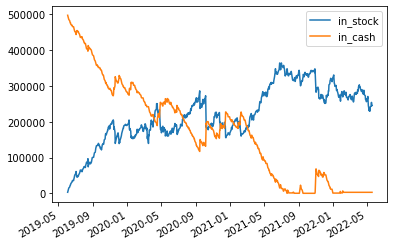

In [670]:
capitalization.plot()